In [1]:
# Import my modules
import GALEX_montage.poisson_segment as ps
import GALEX_montage.cleaning as cl

import os 
from glob import glob
import numpy as np
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib import colors

WDST_GD_153-fd-cnt_nan.fits


Flux  98143.0 aperture size  1.5
original a & b:  141.67339101614022 82.77002745447358
enlarged a & b:  212.51008652421032 124.15504118171037
r =  1400 , cleaned.


2D Gaussian filter completed.
r =  1400 , cleaned.


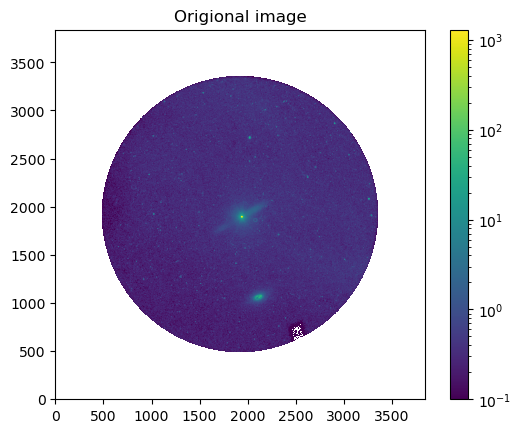

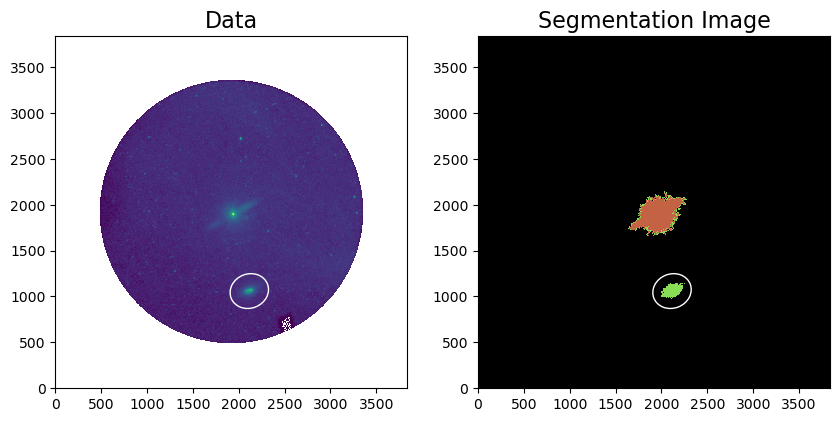

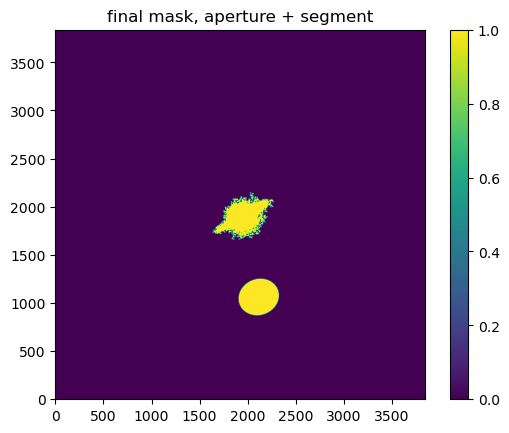

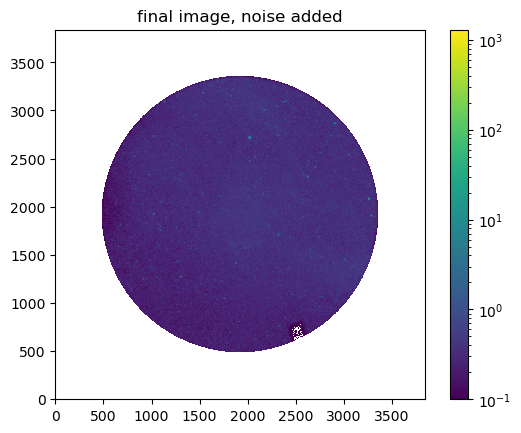

In [2]:
os.getcwd()
path_init = "/home/hina0830/Research/GALEX/raw_files/segmentation_test"
#path_init = "/home/hina0830/Research/GALEX/raw_files/montage_coadd"

os.chdir(path_init)

# Retrieves each type of files in the directory
fn_cnt, fn_rrhr, fn_skybg = sorted(glob('*cnt_nan.fits'), reverse=True), sorted(glob('*rrhr_nan.fits'), reverse=True), sorted(glob('*skybg.fits'), reverse=True)
#fn_cnt, fn_rrhr, fn_skybg = sorted(glob('*cnt_nan.fits')), sorted(glob('*rrhr_nan.fits')), sorted(glob('*skybg.fits'))

for index in range(1):#(len(fn_cnt)):
    cnt, rrhr, skybg = fits.getdata(fn_cnt[index]).astype('float64'), fits.getdata(fn_rrhr[index]).astype('float64'), fits.getdata(fn_skybg[index]).astype('float64')
    hdu = fits.open(fn_cnt[index])
    print(fn_cnt[index])

    fig, ax = plt.subplots()
    plt.imshow(cnt, origin="lower", norm=colors.LogNorm(vmin=0.1, vmax=1300))
    plt.title("Origional image")
    plt.colorbar()
        
    mask = ps.segmentation(cnt, 6500, 0.55) 
    hdu[0].data = mask
    # Save the generated mask
    hdu.writeto(fn_cnt[index].removesuffix('cnt_nan.fits')+'segmask.fits', overwrite=True)
    
    cnt_noise = ps.poisson_noise(cnt, rrhr, mask, skybg)

    # Apply Gaussian filter and clean the edges
    final_cnt = cl.combined(sigma=3.0, radius=1400, data = cnt_noise)

    hdu[0].data = final_cnt
    hdu.writeto("/home/hina0830/Research/GALEX/raw_files/infill/" + fn_cnt[index].removesuffix('_nan.fits')+'_Pnoise_filtered.fits', overwrite=True)


### Star detection and masking 

(0.13076003223062552, 0.0, 0.1657164674012228)
r =  1250 , cleaned.
r =  1250 , cleaned.
19  stars detected


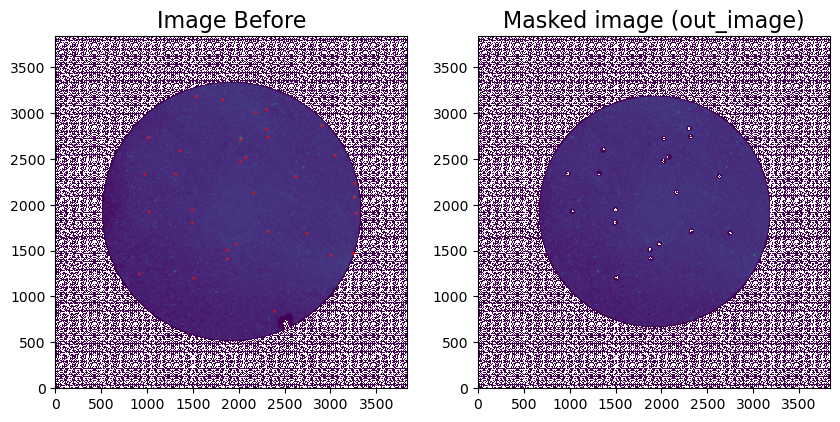

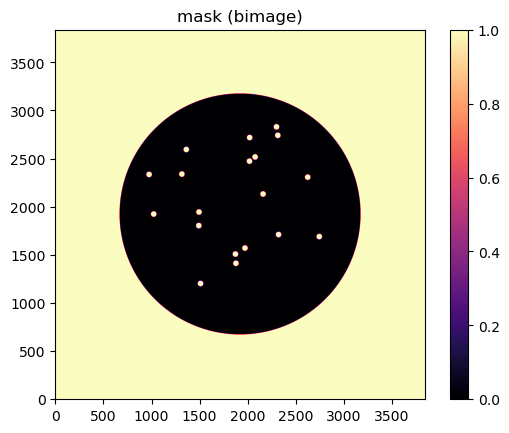

In [5]:
hdu = fits.open("/home/hina0830/Research/GALEX/raw_files/infill/WDST_GD_153-fd-cnt_Pnoise_filtered.fits")
data = (hdu[0].data).astype("float64")

# Define parameters here:
mask_size = 30 # size of mask for each star in pixels
inner_r = 1100 
outer_r = 1250

# Drops nans
data[np.isnan(data)] = 0

mean, median, std = sigma_clipped_stats(data)  
print((mean, median, std))  

daofind = DAOStarFinder(fwhm=3.0, threshold=3.0*std) # 1.5*std 
sources = daofind(data - median)

positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
apertures = CircularAperture(positions, r=4.0)
norm = ImageNormalize(stretch=SqrtStretch())


# Define custom radii for the stars 
star_radii = np.ones(len(sources)) * mask_size

# Mask stars by replacing pixels with 0s
mask_data = np.copy(data)

# create an epmty array, same size as the image
canvas = np.zeros(shape=(data.shape[0], data.shape[1]))

y_indices, x_indices = np.indices(data.shape)
x_cent, y_cent = int(round(len(data) / 2)), int(round(len(data) / 2))
coord_lis = []

for star, radius in zip(sources, star_radii):
    x, y = int(star['xcentroid']), int(star['ycentroid'])

    # Distances between the star and every pixel in the image
    dist = np.sqrt((x_indices - x) ** 2 + (y_indices - y) ** 2) 

    # Mask star; maskd pixels = 0
    mask_data[y, x] = 0

    # Find the distance between the center of the image and the star
    star_dist = np.sqrt((x_cent - x) ** 2 + (y_cent - y) ** 2)

    # Ignore the stars near the edge (outside the inner radius)
    if star_dist <= inner_r: 
        # fill in the pixel around the star and mask the star in the image and the mask
        # the size of masking for each star is mask_size defined at the top
        # masking the image; masked region = 0
        mask_data[dist <= radius] = 0

        # mask file; masked = 1 and nonmasked = 0
        canvas[dist <= radius] = 1

        coord = [x, y]
        coord_lis.append(coord)

# Trim outside pixels
mask_data = ps.zeros_outside(radius = outer_r, data = mask_data)
canvas = cl.nan_outside(radius = outer_r, data = canvas)

canvas[np.isnan(canvas)] = 1
canvas = np.where(mask_data==0, 1, canvas)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 12.5))

ax1.imshow(data, origin="lower", norm=colors.LogNorm(vmin=0.1, vmax=1300))
ax1.set_title("Image Before", fontsize=16)
apertures.plot(ax=ax1, color='red', lw=1.5, alpha=1.)

ax2.imshow(mask_data, origin='lower',norm=colors.LogNorm(vmin=0.1, vmax=1300))#,
           #interpolation='None')

ax2.set_title("Masked image (out_image)", fontsize=16)

fig, ax = plt.subplots()
plt.imshow(canvas,  origin="lower", cmap="magma")
plt.title("mask (bimage)")
plt.colorbar()

print(len(coord_lis), " stars detected")


In [6]:
# Save a list of coordinates of stars
with open("/home/hina0830/Research/GALEX/raw_files/infill/WDST_GD_153-coord.pkl","wb") as f:
    pickle.dump(coord_lis,f)

# Save masked data (out_image)
hdu[0].data = mask_data
f = hdu.writeto("/home/hina0830/Research/GALEX/raw_files/infill/WDST_GD_153-fd-cnt_Pnoise_filtered_masked.fits", overwrite=True) 

# Save mask file (bimage)
hdu[0].data = canvas
f = hdu.writeto("/home/hina0830/Research/GALEX/raw_files/infill/WDST_GD_153-fd-mask.fits", overwrite=True) 